![header](header.png)

# Procesamiento Digital de Señales en Sistemas Embebidos
---


# TP4: Filtrado Digital  *(parte 3)*

## Introducción

El algoritmo Pan-Tompkins se usa comúnmente para detectar complejos QRS en señales electrocardiográficas (ECG). El complejo QRS representa la despolarización ventricular y el pico principal visible en una señal de ECG (ver figura). Esta característica lo hace especialmente adecuado para medir la frecuencia cardíaca, la primera forma de evaluar el estado de salud del corazón.

El algoritmo de Pan-Tompkins aplica una serie de filtros para resaltar el contenido de frecuencia del QRS y eliminar el ruido de fondo. Luego deriva y cuadra la señal para amplificar la contribución QRS, lo que hace que la identificación del complejo QRS sea más sencilla. Finalmente integra la señal y aplica umbrales para detectar los picos.

![pan-tompkins](pan-tompkins.png)

El filtro aplicado en el primer paso para aumentar la relación señal-ruido consiste en un pasa-banda. Se sugiere un ancho de banda de filtro de 5 a 15 Hz para maximizar la contribución de QRS y reducir el ruido muscular, la desviación de la línea de base, la interferencia de la línea eléctrica y el contenido de frecuencia de onda P/onda T. Este filtro estaba originalmente implementado mediante un pasa bajos y un pasa altos, y presentaba una atenuación de aproximadamente 20dB para frecuencias de 1Hz y 50Hz.

## Consignas

A partir de una señal de ECG descargada del Repositorio de Physionet, replicar la acción de filtrado correspondiente a la primera etapa del algoritmo de Pan-Tompkins.
Para ello:
1. Proponer dos diseños de filtros con los requerimientos mencionados, utilizando un filtro de tipo FIR y uno de tipo IIR.
2. Probar dichos filtros sobre un registro de ECG en Python.
3. Implementar ambos filtros en el ESP32, y probarlos también utilizando la misma señal de ECG.

## Envío de señales al ESP32

Para probar los filtros implementados en el ESP32, se procederá a enviar los datos de las señales de la base de datos de Physionet utilizando la comunicación UART disponible (emulando así un AFE o sensor digital).

In [1]:
# Incluir librería WFDB (si no está instalada, instalarla)
try:
    import wfdb
except:
    !pip install wfdb
    import wfdb

In [2]:
# Incluir librerías
from scipy import signal, fft
import numpy as np
import matplotlib.pyplot as plt

### Descarga de registros de Physionet

In [3]:
# carga de la señal utilizando el paquete WFDB
record = wfdb.rdrecord('300', pn_dir='stdb') 

# se extraen los parámetros de la señal correspondiente al primer canal del registro
senial = record.p_signal[:, 0]
fs = record.fs
N = record.sig_len                      # número de muestras
ts = 1 / fs                             # tiempo de muestreo
t = np.linspace(0, N * ts, N)           # vector de tiempo

In [4]:
# Convertir datos de float a int para enviarlos por puerto serie:
Vref = 3300
Bits = record.adc_res[0]
Gan = record.adc_gain[0]

senial_int = (Gan * senial * 2**Bits / Vref).astype(np.int16)

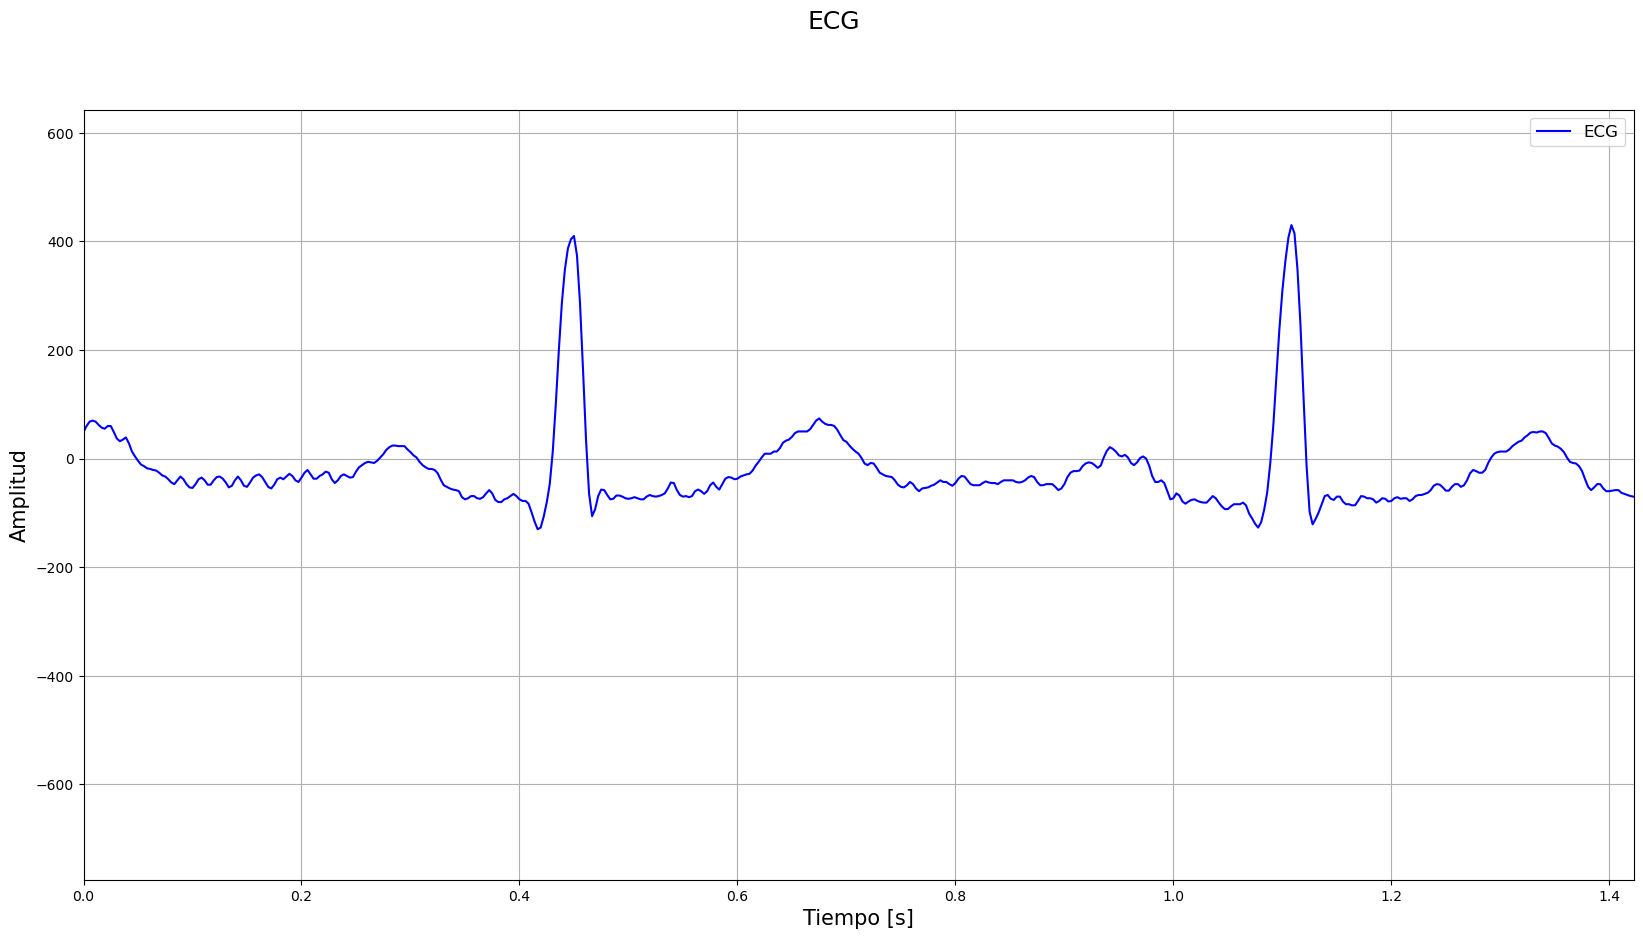

In [5]:
# Graficación de la señal
fig1, ax1 = plt.subplots(1, 1, figsize=(20, 10))
fig1.suptitle('ECG', fontsize=18)

# Se grafica la señal
ax1.plot(t, senial_int, label='ECG', color='blue')
ax1.set_xlabel('Tiempo [s]', fontsize=15)
ax1.set_ylabel('Amplitud', fontsize=15)
ax1.set_xlim([0, ts*512])
ax1.grid()
ax1.legend(fontsize=12)
plt.show()

## Envío de datos por UART

El siguiente bloque de código permite enviar los valores de la señal a través de la UART al ESP32, de a uno en uno a una tasa de `ts` segundos.

También permite visualizar la salida por terminal generada por el ESP32 (simulando el monitor).

Para probarlo, cargar el ejemplo de C `uart_plot` en el ESP y luego ejecutar las celdas siguientes (configurando previamente el nombre del puerto).

> Nota: 
>
> Para manejar puerto serie desde python: [pySerial](https://pyserial.readthedocs.io/en/latest/pyserial.html)
> 
> Para ejecutar múltiples tareas al mismo tiempo: [threading](https://docs.python.org/es/3.8/library/threading.html)

In [9]:
# Incluir librería pySerial (si no está instalada, instalarla)
try:
    import serial
except:
    !pip install pyserial
    import serial

In [19]:
import threading
import time
import struct
from ipywidgets import IntProgress, Output, Button
from IPython.display import display

puerto = "COM4"
N_muestras = 60 * fs # 60 segundos de señal
#N_muestras = N      # señal completa

# Configurar puerto serie
ser = serial.Serial(puerto,
                    921600,
                    timeout=5,
                    write_timeout=5,
                    bytesize=serial.EIGHTBITS,
                    parity=serial.PARITY_NONE,
                    stopbits=serial.STOPBITS_ONE,
                    rtscts=True)

recibiendo = True
enviando = True
    
# Barra de avance
bar = IntProgress(min=0, max=N_muestras) 
# Monitor
out = Output(layout={'border': '1px solid black',
                     'height': '400px',
                     'overflow': 'hidden scroll'})

# Tarea de envío de datos
def send_data(target, count): 
    t_start = time.time()
    global recibiendo, enviando
    
    sig_bytes = struct.pack('h', senial_int[count])  # Extraer los bytes de cada dato
    try:
        ser.write(sig_bytes)                         # Escribir datos en el puerto serie
    except:
        print("Error al escribir en el puerto")
        enviando = False
    bar.value += 1 
    count += 1
    if count < N_muestras and enviando:
        # Volver a ejecutar la función ts segundos después
        t = time.time() - t_start
        threading.Timer(target-time.time()-t, send_data, [target+ts, count]).start() 
    else:
        recibiendo = False
        print("Envío de señal finalizado.")

# Tarea de recepción de datos
def receive_data():
    global recibiendo
    
    # Mostrar widgets
    print(f"Duración de la señal {(N_muestras*ts):.0f} segundos")
    print("Enviando señal:")
    display(bar) 
    display(out)
    
    # Reset ESP32
    ser.dtr = False
    time.sleep(0.2)
    ser.dtr = True
    ser.rtscts = False
    
    #Iniciar envío de datos
    target = time.time() + ts
    send_data(target, count=0)
    
    while(recibiendo):
        line = ser.read_until()
        if(line != b''):
            try:
                line = line.decode("utf-8").strip('\n')
            except:
                line = ''
            with out:
                print(line)

# Iniciar recepción
receive_thread = threading.Thread(name='receive_data', target=receive_data)
receive_thread.start()

receive_thread.join()
# Cerrar el puerto
ser.close()

Duración de la señal 60 segundos
Enviando señal:


IntProgress(value=0, max=21600)

Output(layout=Layout(border='1px solid black', height='400px', overflow='hidden scroll'))

Envío de señal finalizado.
